In [1]:
from scipy.stats import vonmises,skewnorm
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from tqdm import tqdm
import numpy as np
import ot

from lcot import LCOT
from lcot.measures import measure,empirical_measure,ot_1d
from lcot.visualize import plot_circle_pdf

## Experiment 1

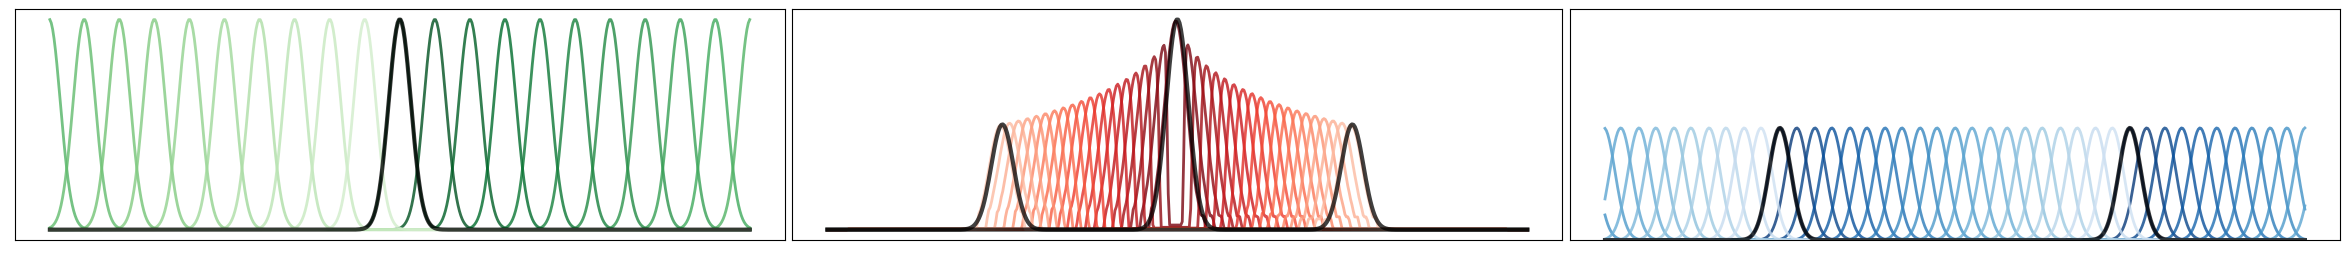

In [2]:
x = np.linspace(-np.pi, np.pi, 500)
t = np.linspace(0, 1, 500)

mu = vonmises.pdf(0, 100, x)
nu = .5*(vonmises.pdf(np.pi/2, 100,x)+vonmises.pdf(-np.pi/2, 100,x))
lcot = LCOT(t)
muhat = lcot.forward(measure([t,mu]))
nuhat = lcot.forward(measure([t,nu]))

K=20

def generate_color_gradient(num_colors,base_color):
    cmap = plt.cm.get_cmap(base_color)
    colors = cmap(np.linspace(1, 0, num_colors))
    return colors

class_colors=[]
class_colors.append(generate_color_gradient(K+5,'Greens'))
class_colors.append(generate_color_gradient(K+5,'Reds'))
class_colors.append(generate_color_gradient(K+5,'Blues'))


fig,ax = plt.subplots(1,3,figsize=(10*3,3))
rs = (np.linspace(0,500,K+1)[:-1]).astype(int)
measures=[]
alpha = .8*np.ones(K)
for i,r in enumerate(rs):
  temp = np.roll(mu,r)
  measures.append(measure([t,temp]))
  ax[0].plot(t,temp,linewidth=2,c=class_colors[0][i],alpha=alpha[i])

rs = (np.linspace(0,250,K+1)[:-1]).astype(int)
for i,r in enumerate(rs):
  temp = np.roll(nu,r)
  measures.append(measure([t,temp]))
  ax[2].plot(t,temp,linewidth=2,c=class_colors[2][i],alpha=alpha[i])


for i,a in enumerate(np.linspace(0,1,K)):
  nuH = lcot.inverse((1-a)*muhat+a*nuhat)
  nuH.density_y[-15:]=0
  nuH.density_y[:15]=0
  measures.append(nuH)
  ax[1].plot(t,nuH.density_y ,linewidth=2,c=class_colors[1][i],alpha=alpha[i])

ax[0].plot(t,mu,linewidth=3,c='k',alpha=.75)
ax[2].plot(t,nu,linewidth=3,c='k',alpha=.75)
ax[1].plot(t,nu,linewidth=3,c='k',alpha=.75)
ax[1].plot(t,mu,linewidth=3,c='k',alpha=.75)
for i in range(3):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[2].set_ylim(0,4.1)
plt.subplots_adjust(wspace=.01, hspace=0)
plt.show()

In [3]:
#@title # Pairwise distances
lcot = LCOT(t)
mat_lin_COT = np.zeros([len(measures),len(measures)])
mat_COT = np.zeros([len(measures),len(measures)])
mat_OT = np.zeros([len(measures),len(measures)])
mat_euclidean = np.zeros([len(measures),len(measures)])
L = 2500
for i in tqdm(range(len(measures)-1)):
  for j in range(i+1,len(measures)):
    mat_lin_COT[i,j] = lcot.cost(measures[i],measures[j])
    samples_i = measures[i].sample(L)
    samples_j = measures[j].sample(L)
    mat_COT[i,j] = ot.binary_search_circle(samples_i, samples_j, p=2)
    mat_OT[i,j] = ot_1d(samples_i,samples_j)
    min_sample = min(samples_i.min(), samples_j.min())
    max_sample = max(samples_i.max(), samples_j.max())
    h1, _ = np.histogram(samples_i, bins=360, range=(min_sample, max_sample), density=True)
    h2, _ = np.histogram(samples_j, bins=360, range=(min_sample, max_sample), density=True)
    mat_euclidean[i, j] = (np.sum((h1-h2)**2)/360)**0.5

mat_lin_COT = mat_lin_COT + mat_lin_COT.T
mat_COT = mat_COT + mat_COT.T
mat_OT = mat_OT + mat_OT.T
mat_euclidean = mat_euclidean + mat_euclidean.T


 14%|█▎        | 8/59 [00:05<00:40,  1.26it/s]/home/liux31/miniconda3/envs/ppcr/lib/python3.10/site-packages/ot/lp/solver_1d.py:726: RuntimeWarning: divide by zero encountered in true_divide
  tc[mask_end > 0] = ((Ctp - Ctm + tm * dCptm - tp * dCmtp) / (dCptm - dCmtp))[mask_end > 0]
100%|██████████| 59/59 [00:26<00:00,  2.23it/s]


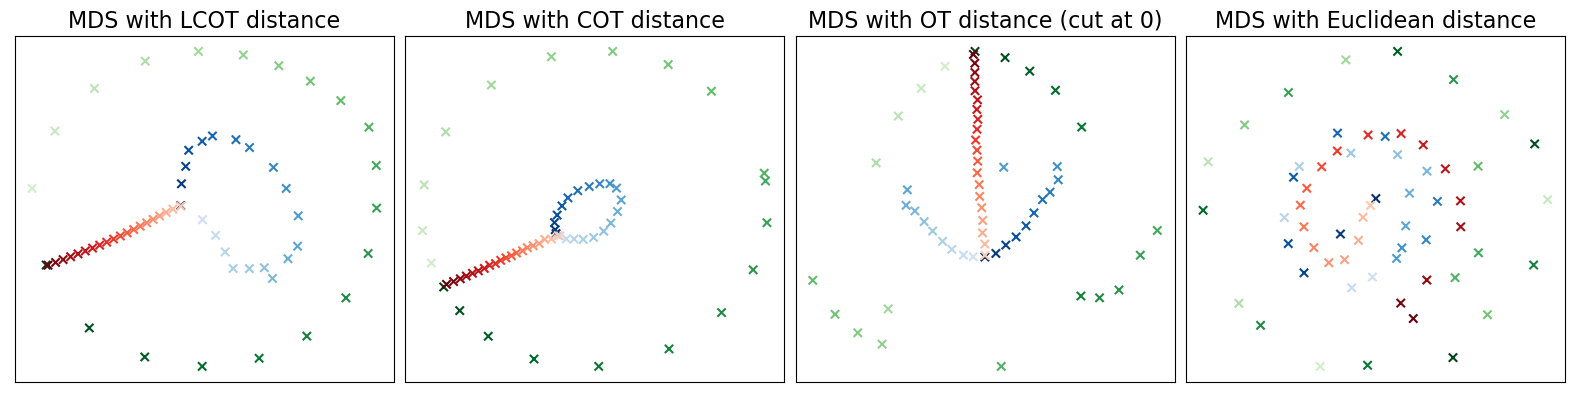

In [4]:
dissimilarity_matrix_LCOT = mat_lin_COT
dissimilarity_matrix_COT = mat_COT
dissimilarity_matrix_OT = mat_OT
dissimilarity_matrix_euclidean = mat_euclidean
len_measures = K
fs = 16
# Create an instance of MDS
mds = MDS(n_components=2, dissimilarity='precomputed',random_state=0, normalized_stress=False)

lower_dimensional_points_LCOT = mds.fit_transform(dissimilarity_matrix_LCOT)
lower_dimensional_points_COT = mds.fit_transform(dissimilarity_matrix_COT)
lower_dimensional_points_OT = mds.fit_transform(dissimilarity_matrix_OT)
lower_dimensional_points_euclidean = mds.fit_transform(dissimilarity_matrix_euclidean)


fig, ax = plt.subplots(1,4, figsize = (4*5,4.5))
# Plot the lower-dimensional points
lower_dimensional_points = lower_dimensional_points_LCOT
ax[0].scatter(lower_dimensional_points[:len_measures, 0], lower_dimensional_points[:len_measures, 1], c=class_colors[0][:K], marker = 'x')
ax[0].scatter(lower_dimensional_points[len_measures:2*len_measures, 0], lower_dimensional_points[len_measures:2*len_measures, 1], c=class_colors[2][:K], marker = 'x',label = '1 Bump')
ax[0].scatter(lower_dimensional_points[2*len_measures:, 0], lower_dimensional_points[2*len_measures:, 1], c=class_colors[1][:K], marker = 'x',label = '2 Bumps')
# plt.xlabel('Dimension 1')
# plt.ylabel('Dimension 2')
ax[0].set_title('MDS with LCOT distance',fontsize=fs)
#plt.axis('square')
#plt.legend()
#plt.show()

lower_dimensional_points = lower_dimensional_points_COT
ax[1].scatter(lower_dimensional_points[:len_measures, 0], lower_dimensional_points[:len_measures, 1], c=class_colors[0][:K], marker = 'x')
ax[1].scatter(lower_dimensional_points[len_measures:2*len_measures, 0], lower_dimensional_points[len_measures:2*len_measures, 1], c=class_colors[2][:K], marker = 'x',label = "1 Bump")
ax[1].scatter(lower_dimensional_points[2*len_measures:, 0], lower_dimensional_points[2*len_measures:, 1], c=class_colors[1][:K], marker = 'x',label = '2 Bumps')
# plt.xlabel('Dimension 1')
# plt.ylabel('Dimension 2')
ax[1].set_title('MDS with COT distance',fontsize=fs)
# plt.axis('square')
# plt.legend()
# plt.show()

lower_dimensional_points = lower_dimensional_points_OT
ax[2].scatter(lower_dimensional_points[:len_measures, 0], lower_dimensional_points[:len_measures, 1], c=class_colors[0][:K], marker = 'x')
ax[2].scatter(lower_dimensional_points[len_measures:2*len_measures, 0], lower_dimensional_points[len_measures:2*len_measures, 1], c=class_colors[2][:K], marker = 'x',label = '1 Bump')
ax[2].scatter(lower_dimensional_points[2*len_measures:, 0], lower_dimensional_points[2*len_measures:, 1], c=class_colors[1][:K], marker = 'x',label = '2 Bumps')
# plt.xlabel('Dimension 1')
# plt.ylabel('Dimension 2')
ax[2].set_title('MDS with OT distance (cut at 0)',fontsize = fs)
# plt.axis('square')
# plt.legend()
# plt.show()

lower_dimensional_points = lower_dimensional_points_euclidean
ax[3].scatter(lower_dimensional_points[:len_measures, 0], lower_dimensional_points[:len_measures, 1], c=class_colors[0][:K], marker = 'x')
ax[3].scatter(lower_dimensional_points[len_measures:2*len_measures, 0], lower_dimensional_points[len_measures:2*len_measures, 1], c=class_colors[2][:K], marker = 'x',label = '1 Bump')
ax[3].scatter(lower_dimensional_points[2*len_measures:, 0], lower_dimensional_points[2*len_measures:, 1], c=class_colors[1][:K], marker = 'x',label = '2 Bumps')
# plt.xlabel('Dimension 1')
# plt.ylabel('Dimension 2')
ax[3].set_title('MDS with Euclidean distance',fontsize= fs)
# plt.axis('square')
# plt.legend()

for i in range(4):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.subplots_adjust(wspace=.03, hspace=0)
plt.show()

## Experiment 2

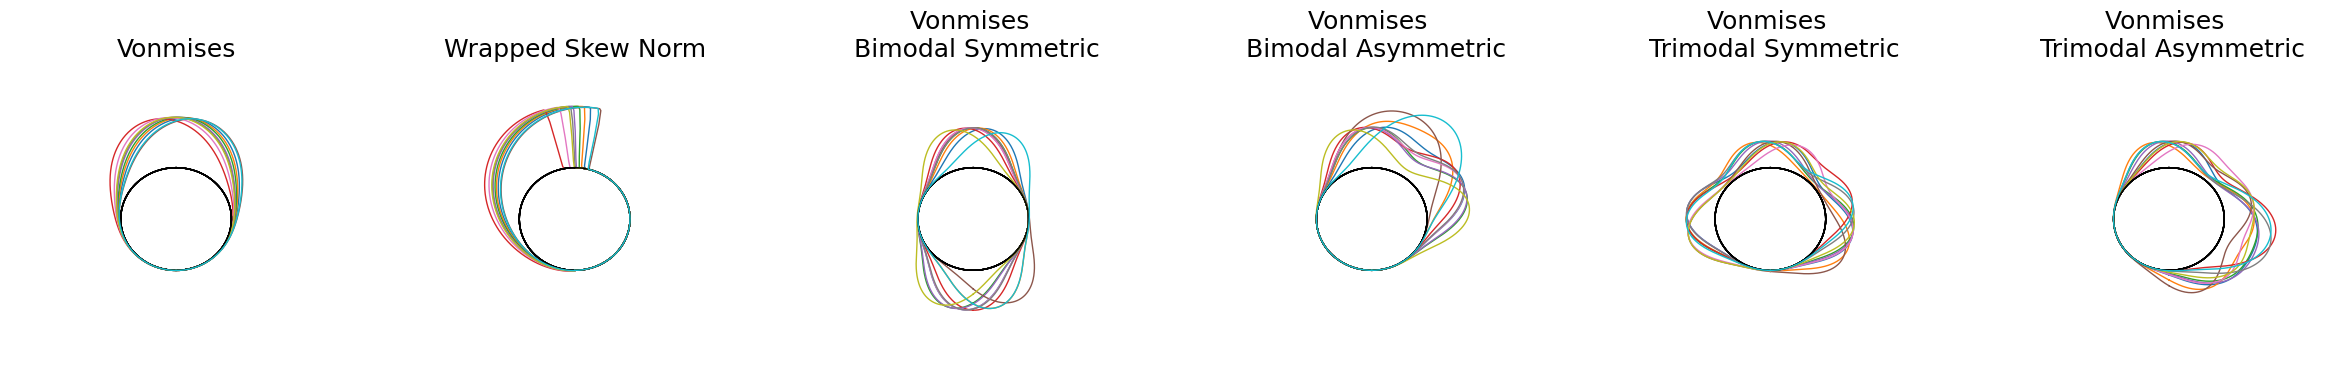

In [5]:
#@title # Visualizing Densities
fig , ax = plt.subplots(1,6,figsize=(30,4))
loc = 0
kappa = 3
scale =.75
kappa_rand = 25
x = np.linspace(-np.pi, np.pi, 500)
t = np.linspace(0, 1, 500)
np.random.seed(1)
for i in range(10):
  mean_loc = vonmises(loc=0, kappa=kappa_rand).rvs(1)
  vonmises_pdf = vonmises.pdf(mean_loc, kappa, x)
  plot_circle_pdf(t, vonmises_pdf,scale=scale, alpha=1,ax=ax[0])

a = 100
x = np.linspace(-np.pi,
                  np.pi, 500)
t = np.linspace(0, 1, 500)
# fig, ax = plt.subplots(1,1,figsize=(5,5))
np.random.seed(1)
for i in range(10):
  mean_loc = vonmises(loc=0, kappa=kappa_rand).rvs(1)
  rv = skewnorm(a, loc=mean_loc[0], scale=1.)
  plot_circle_pdf(t, rv.pdf(x),scale=scale,ax=ax[1])

## Vonmises bimodal
loc1 = 0
loc2 = np.pi
kappa = 7
x = np.linspace(-np.pi, np.pi, 500)
t = np.linspace(0, 1, 500)
# fig, ax = plt.subplots(1,1,figsize=(5,5))
np.random.seed(1)
for i in range(10):
  mean_locs = vonmises(loc=0, kappa=kappa_rand).rvs(2)
  vonmises_1_pdf = vonmises.pdf(loc1+mean_locs[0], kappa, x)/2
  vonmises_2_pdf = vonmises.pdf(loc2+mean_locs[1], kappa, x)/2
  plot_circle_pdf(t, vonmises_1_pdf + vonmises_2_pdf, scale=scale,alpha=1,ax=ax[2])


## Vonmises bimodal asymmetric
loc1 = 0
loc2 = -np.pi/3.
kappa = 7
x = np.linspace(-np.pi, np.pi, 500)
t = np.linspace(0, 1, 500)
# fig, ax = plt.subplots(1,1,figsize=(5,5))
np.random.seed(1)
for i in range(10):
  mean_locs = vonmises(loc=0, kappa=kappa_rand).rvs(2)
  vonmises_1_pdf = vonmises.pdf(loc1+mean_locs[0], kappa, x)/2
  vonmises_2_pdf = vonmises.pdf(loc2+mean_locs[1], kappa, x)/2
  plot_circle_pdf(t, vonmises_1_pdf + vonmises_2_pdf, alpha=1,scale=scale,ax=ax[3])


## Vonmises trimodal
loc1 = 0
# loc2 = -np.pi*2/3
# loc3 = np.pi*2/3
loc2=np.pi/2
loc3=-np.pi*200/360
kappa = 7
x = np.linspace(-np.pi, np.pi, 500)
t = np.linspace(0, 1, 500)
# fig, ax = plt.subplots(1,1,figsize=(5,5))
np.random.seed(1)
for i in range(10):
  mean_locs = vonmises(loc=0, kappa=kappa_rand).rvs(3)
  vonmises_1_pdf = vonmises.pdf(loc1+mean_locs[0], kappa, x)/3
  vonmises_2_pdf = vonmises.pdf(loc2+mean_locs[1], kappa, x)/3
  vonmises_3_pdf = vonmises.pdf(loc3+mean_locs[2], kappa, x)/3
  plot_circle_pdf(t, vonmises_1_pdf + vonmises_2_pdf + vonmises_3_pdf, scale=scale, alpha=1,ax=ax[4])

## Vonmises trimodal Asymmetric
loc1=0
loc2=-np.pi/2,
loc3=-np.pi*270/360
# fig, ax = plt.subplots(1,1,figsize=(5,5))
np.random.seed(1)
for i in range(10):
  mean_locs = vonmises(loc=0, kappa=kappa_rand).rvs(3)
  vonmises_1_pdf = vonmises.pdf(loc1+mean_locs[0], kappa, x)/3
  vonmises_2_pdf = vonmises.pdf(loc2+mean_locs[1], kappa, x)/3
  vonmises_3_pdf = vonmises.pdf(loc3+mean_locs[2], kappa, x)/3
  plot_circle_pdf(t, vonmises_1_pdf + vonmises_2_pdf + vonmises_3_pdf, scale=scale,alpha=1,ax=ax[5])

titles = [
    'Vonmises','Wrapped Skew Norm',
    'Vonmises \n Bimodal Symmetric','Vonmises \n Bimodal Asymmetric',
    'Vonmises \n Trimodal Symmetric','Vonmises \n Trimodal Asymmetric']
for i in range(6):
    ax[i].axis('off')
    plt.subplots_adjust(wspace=None, hspace=None)
    ax[i].set_title(titles[i],fontsize=18)
    ax[i].set_ylim([-1.5,1.5])
    ax[i].set_xlim([-1.5,1.5])


In [6]:
#@title # Generating Samples
# Vonmises
def Vonmises(num_samples, locs, kappa=3, alpha=30, perturb=0):
  '''
    locs: a list of mode center locations
  '''
  num_mode = len(locs)
  mean_loc = vonmises(loc=perturb, kappa=alpha).rvs(num_mode)
  samples = []
  for i in range(num_mode):
    s = vonmises(loc=locs[i]+mean_loc[i], kappa=kappa).rvs(int(num_samples/num_mode))
    samples.append(s)
  samples = np.concatenate(samples, axis=0)
  samples = (samples-samples.min()) / (samples.max()-samples.min())
  return empirical_measure(samples)
# Skewnorm
def Skew_norm(num_samples, a=100, scale=1, alpha=30, perturb=np.pi):
  mean_loc = vonmises(loc=perturb, kappa=alpha).rvs(1)
  rv = skewnorm(a, loc=mean_loc, scale=scale)
  samples = rv.rvs(num_samples)
  samples = (samples-samples.min()) / (samples.max()-samples.min())
  return empirical_measure(samples)

np.random.seed(0)
measures = []
label = []
min_ = 50
max_ = 100
for i in range(20):
  num1 = np.random.randint(min_, high=max_)
  measures.append(Vonmises(num1, locs=[np.pi]))

  num2 = np.random.randint(min_, high=max_)
  measures.append(Skew_norm(num2))

  num3 = np.random.randint(min_, high=max_)
  measures.append(Vonmises(num3, locs=[0, np.pi]))

  num4 = np.random.randint(min_, high=max_)
  measures.append(Vonmises(num4, locs=[np.pi, -np.pi*2/3]))

  num5 = np.random.randint(min_, high=max_)
  measures.append(Vonmises(num5, locs=[np.pi, np.pi/3, -np.pi/3], kappa=5))

  num6 = np.random.randint(min_, high=max_)
  measures.append(Vonmises(num6, locs=[np.pi, -np.pi/2, -np.pi*4/9], kappa=5))

  label.extend(range(6))
label = np.array(label)

In [7]:
#@title # Pairwise distances
lcot = LCOT(t)
mat_lin_COT = np.zeros([len(measures),len(measures)])
mat_COT = np.zeros([len(measures),len(measures)])
mat_OT = np.zeros([len(measures),len(measures)])
mat_euclidean = np.zeros([len(measures),len(measures)])
for i in tqdm(range(len(measures)-1)):
  for j in range(i+1,len(measures)):
    mat_lin_COT[i,j] = lcot.cost(measures[i],measures[j])
    mat_COT[i,j] = ot.binary_search_circle(measures[i].samples, measures[j].samples, p=2)
    mat_OT[i,j] = ot_1d(measures[i].samples,measures[j].samples)
    min_sample = min(measures[i].samples.min(), measures[j].samples.min())
    max_sample = max(measures[i].samples.max(), measures[j].samples.max())
    h1, _ = np.histogram(measures[i].samples, bins=360, range=(min_sample, max_sample), density=True)
    h2, _ = np.histogram(measures[j].samples, bins=360, range=(min_sample, max_sample), density=True)
    mat_euclidean[i, j] = (np.sum((h1-h2)**2)/360)**0.5

mat_lin_COT = mat_lin_COT + mat_lin_COT.T
mat_COT = mat_COT + mat_COT.T
mat_OT = mat_OT + mat_OT.T
mat_euclidean = mat_euclidean + mat_euclidean.T


100%|██████████| 119/119 [00:46<00:00,  2.57it/s]


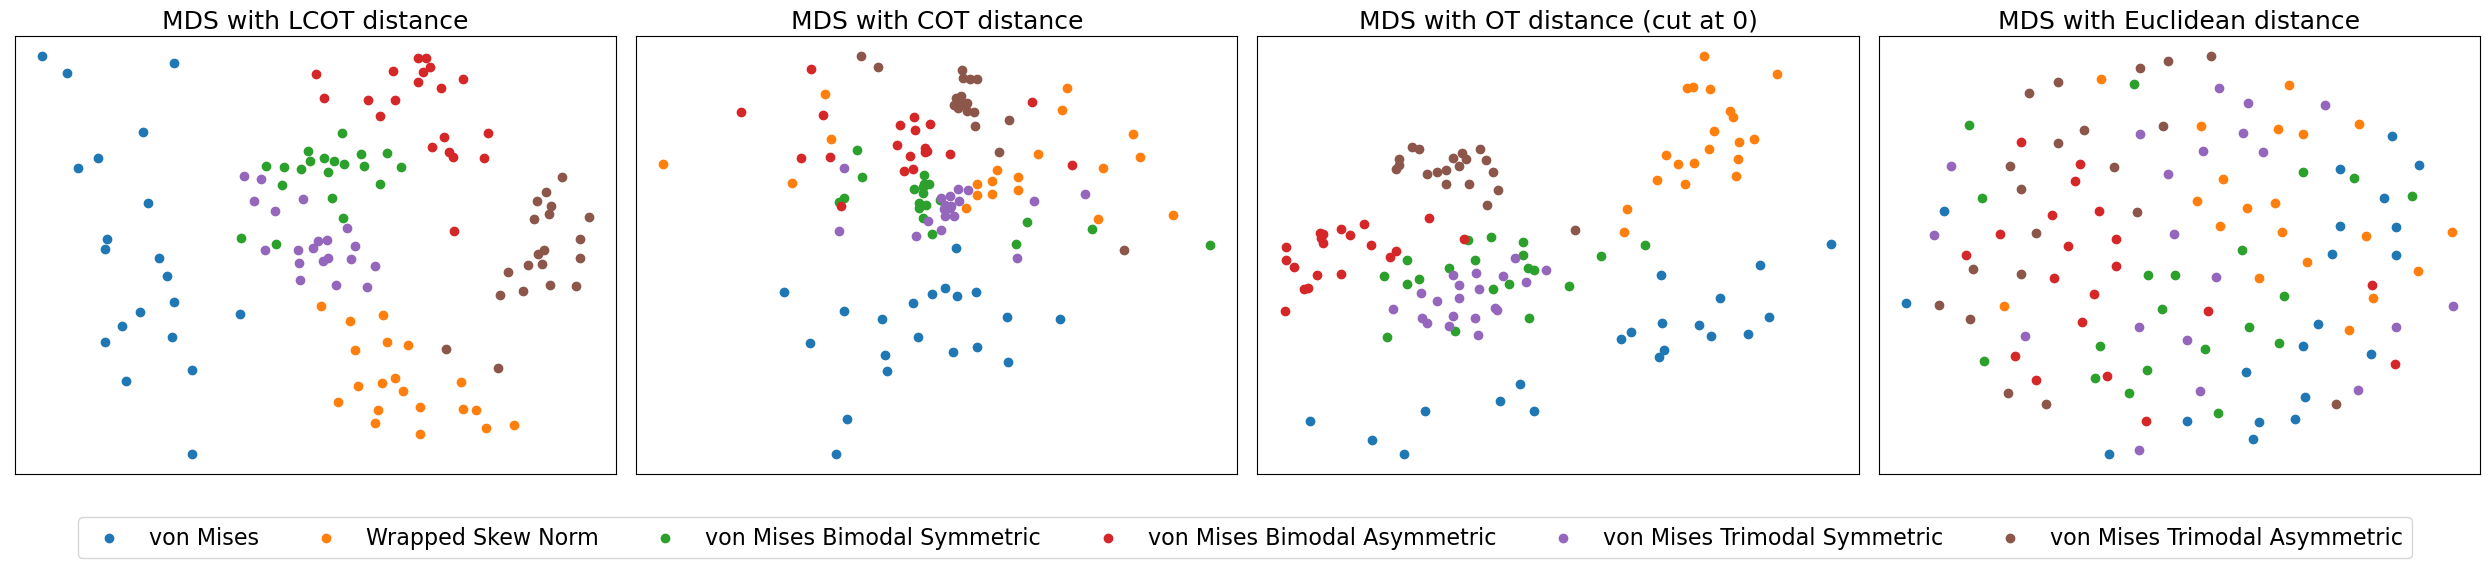

In [8]:
mds = MDS(n_components=2, dissimilarity='precomputed',random_state=0, normalized_stress='auto')
lower_dimensional_points_LCOT = mds.fit_transform(mat_lin_COT)
lower_dimensional_points_COT = mds.fit_transform(mat_COT)
lower_dimensional_points_OT = mds.fit_transform(mat_OT)
lower_dimensional_points_euclidean = mds.fit_transform(mat_euclidean)

titles = [
    'von Mises','Wrapped Skew Norm',
    'von Mises Bimodal Symmetric','von Mises Bimodal Asymmetric',
    'von Mises Trimodal Symmetric','von Mises Trimodal Asymmetric']
fig, ax = plt.subplots(1,4, figsize = (25,5))
for i in range(6):
  ax[0].scatter(lower_dimensional_points_LCOT[label==i,0], lower_dimensional_points_LCOT[label==i,1], label = titles[i])
  ax[0].set_title('MDS with LCOT distance',fontsize=18)
  ax[1].scatter(lower_dimensional_points_COT[label==i,0], lower_dimensional_points_COT[label==i,1], label = titles[i])
  ax[1].set_title('MDS with COT distance',fontsize=18)
  ax[2].scatter(lower_dimensional_points_OT[label==i,0], lower_dimensional_points_OT[label==i,1], label = titles[i])
  ax[2].set_title('MDS with OT distance (cut at 0)',fontsize=18)
  ax[3].scatter(lower_dimensional_points_euclidean[label==i,0], lower_dimensional_points_euclidean[label==i,1],label = titles[i])
  ax[3].set_title('MDS with Euclidean distance',fontsize=18)

for i in range(4):
  ax[i].set_xticks([])
  ax[i].set_yticks([])
fig.tight_layout()

lines, labels = ax[2].get_legend_handles_labels()
fig.legend(lines, labels,loc='lower center',fontsize=16,ncol=6,bbox_to_anchor=(0.5,-0.15))

## Experiment 3

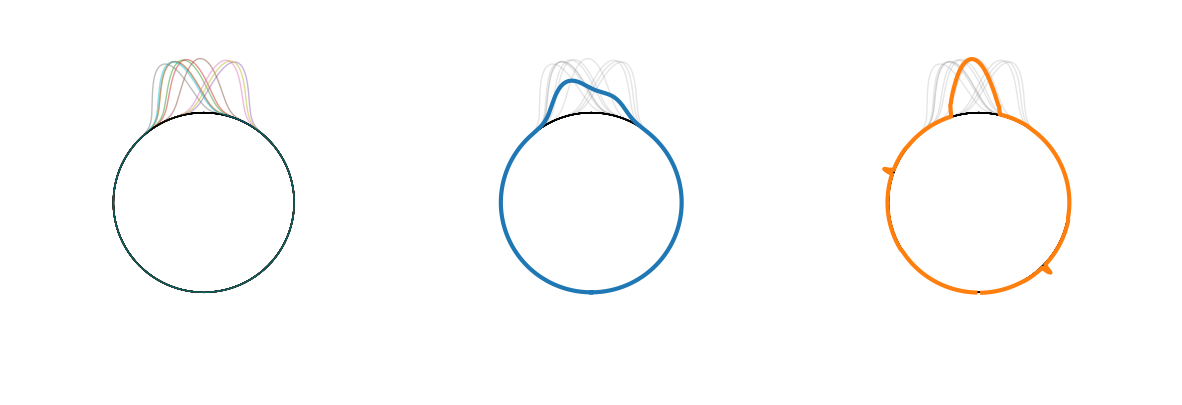

In [9]:
#@title # Generate Densities
np.random.seed(0)
fig , ax = plt.subplots(1,3,figsize=(15,5))
# Initialize measures and labels
measures = []
embeddings = []
# Number of measures per class
M = 10
eps = .7
# Parameters of the unimodal von Mises
loc = 0
kappa = 50
scale =.15
kappa_rand = 30
for i in range(M):
  mean_loc = vonmises(loc=0, kappa=kappa_rand).rvs(1)
  pdf = vonmises.pdf(mean_loc+loc, kappa, x)      
  nu = measure([t,pdf])
  measures.append(pdf)
  embeddings.append(lcot.forward(nu))
  plot_circle_pdf(t, pdf,ax=ax[0],alpha=.5,c=None,scale=scale,eps=eps)
  plot_circle_pdf(t, pdf,ax=ax[1],alpha=.2,c='gray',scale=scale,eps=eps)
  plot_circle_pdf(t, pdf,ax=ax[2],alpha=.2,c='gray',scale=scale,eps=eps)

Euclidean_barycenter = np.stack(measures,0).mean(0)
plot_circle_pdf(t, Euclidean_barycenter,ax=ax[1],alpha=1.,c='C0',scale=scale,eps=eps,linewidth=3)
embedd_mean = np.stack(embeddings,0).mean(0)
LCOT_barycenter = lcot.inverse(embedd_mean)
lcot_bary = LCOT_barycenter.density_y
tau=3
plot_circle_pdf(t[tau:-tau],lcot_bary[tau:-tau] ,ax=ax[2],alpha=1.,c='C1',scale=scale,eps=eps,linewidth=3)


for m in range(3):
  ax[m].set_yticks([])
  ax[m].set_xticks([])
  ax[m].set_ylim([-1.5,1.5])
  ax[m].set_xlim([-1.5,1.5])
  ax[m].axis('off')
plt.subplots_adjust(wspace=0, hspace=0)

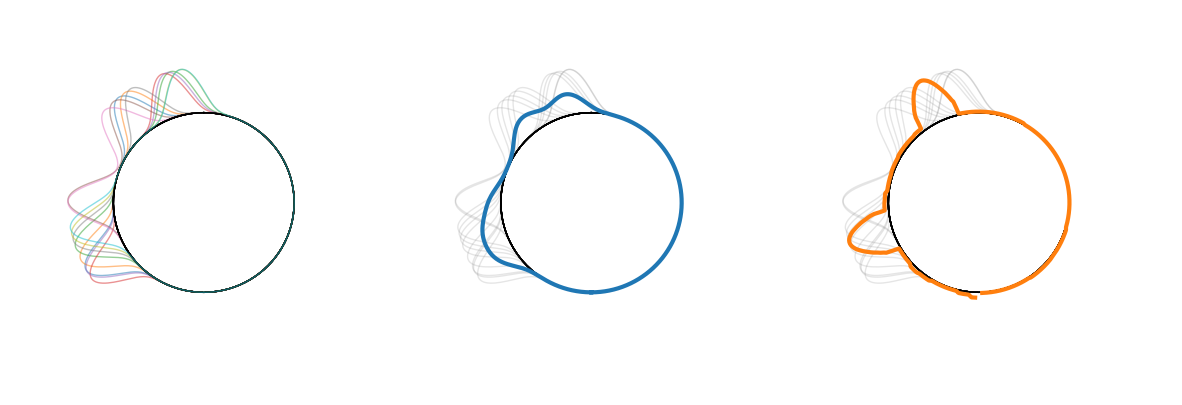

In [10]:
#@title # Generate Densities
np.random.seed(0)
fig , ax = plt.subplots(1,3,figsize=(15,5))
# Initialize measures and labels
measures = []
embeddings = []
# Number of measures per class
M = 10
eps = .7
scale = .25
# Parameters of the unimodal von Mises
loc1 = .15*np.pi
loc2 = .6*np.pi
for i in range(M):
  mean_locs = vonmises(loc=0, kappa=kappa_rand).rvs(2)
  vonmises_1_pdf = vonmises.pdf(loc1+mean_locs[0], kappa, x)/2
  vonmises_2_pdf = vonmises.pdf(loc2+mean_locs[1], kappa, x)/2
  pdf = vonmises_1_pdf + vonmises_2_pdf
  nu = measure([t,pdf])
  measures.append(pdf)
  embeddings.append(lcot.forward(nu))
  plot_circle_pdf(t, pdf,ax=ax[0],alpha=.5,c=None,scale=scale,eps=eps)
  plot_circle_pdf(t, pdf,ax=ax[1],alpha=.2,c='gray',scale=scale,eps=eps)
  plot_circle_pdf(t, pdf,ax=ax[2],alpha=.2,c='gray',scale=scale,eps=eps)

Euclidean_barycenter = np.stack(measures,0).mean(0)
plot_circle_pdf(t, Euclidean_barycenter,ax=ax[1],alpha=1.,c='C0',scale=scale,eps=eps,linewidth=3)
embedd_mean = np.stack(embeddings,0).mean(0)
LCOT_barycenter = lcot.inverse(embedd_mean)
lcot_bary = LCOT_barycenter.density_y
tau=3
plot_circle_pdf(t[tau:-tau],lcot_bary[tau:-tau] ,ax=ax[2],alpha=1.,c='C1',scale=scale,eps=eps,linewidth=3)


for m in range(3):
  ax[m].set_yticks([])
  ax[m].set_xticks([])
  ax[m].set_ylim([-1.5,1.5])
  ax[m].set_xlim([-1.5,1.5])
  ax[m].axis('off')
plt.subplots_adjust(wspace=0, hspace=0)

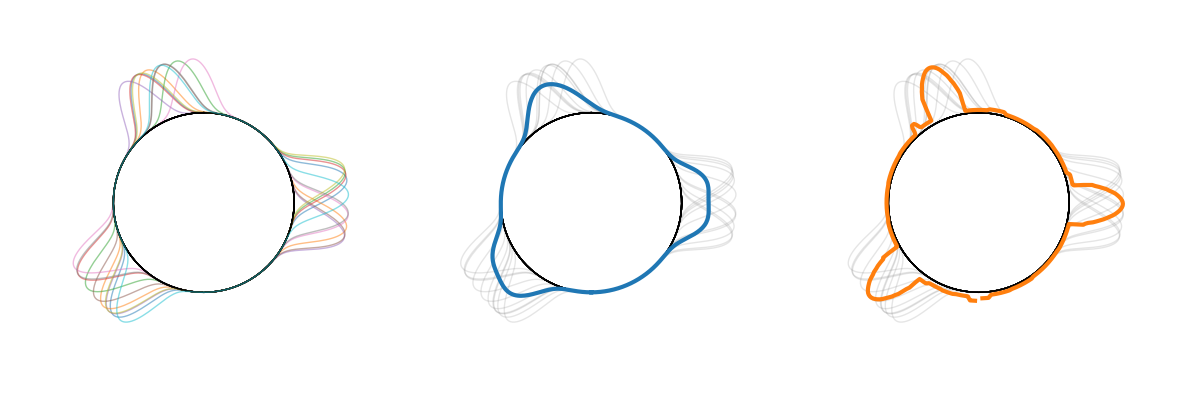

In [11]:
#@title # Generate Densities
np.random.seed(0)
fig , ax = plt.subplots(1,3,figsize=(15,5))
# Initialize measures and labels
measures = []
embeddings = []
# Number of measures per class
M = 10
eps = .7
scale = .45
# Parameters of the unimodal von Mises
## Vonmises trimodal Asymmetric
loc1= .1*np.pi
loc2=-.5*np.pi
loc3=.75*np.pi
kappa_rand = 50
for i in range(M):
  mean_locs = vonmises(loc=0, kappa=kappa_rand).rvs(3)
  vonmises_1_pdf = vonmises.pdf(loc1+mean_locs[0], kappa, x)/3
  vonmises_2_pdf = vonmises.pdf(loc2+mean_locs[1], kappa, x)/3
  vonmises_3_pdf = vonmises.pdf(loc3+mean_locs[2], kappa, x)/3
  pdf = vonmises_1_pdf + vonmises_2_pdf + vonmises_3_pdf  
  nu = measure([t,pdf])
  measures.append(pdf)
  embeddings.append(lcot.forward(nu))
  plot_circle_pdf(t, pdf,ax=ax[0],alpha=.5,c=None,scale=scale,eps=eps)
  plot_circle_pdf(t, pdf,ax=ax[1],alpha=.2,c='gray',scale=scale,eps=eps)
  plot_circle_pdf(t, pdf,ax=ax[2],alpha=.2,c='gray',scale=scale,eps=eps)

Euclidean_barycenter = np.stack(measures,0).mean(0)
plot_circle_pdf(t, Euclidean_barycenter,ax=ax[1],alpha=1.,c='C0',scale=scale,eps=eps,linewidth=3)
embedd_mean = np.stack(embeddings,0).mean(0)
LCOT_barycenter = lcot.inverse(embedd_mean)
lcot_bary = LCOT_barycenter.density_y
tau=3
plot_circle_pdf(t[tau:-tau],lcot_bary[tau:-tau] ,ax=ax[2],alpha=1.,c='C1',scale=scale,eps=eps,linewidth=3)


for m in range(3):
  ax[m].set_yticks([])
  ax[m].set_xticks([])
  ax[m].set_ylim([-1.5,1.5])
  ax[m].set_xlim([-1.5,1.5])
  ax[m].axis('off')
plt.subplots_adjust(wspace=0, hspace=0)